# Objectives:
## Import and clean the data for the following tasks
## 1. Explore the relationships Country - nutrition score and fat/energy - nutrition score
## 2. Find the most common ingredients
## 3. Time-series analysis
## 4. Create a database 
## 5. Analysis of nutrition score

In [58]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import sqlite3
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

sns.set(rc={'figure.figsize':(18,8.27)})

## Importing

In [3]:
data = pd.read_csv('en.openfoodfacts.org.products.tsv', sep='\t') 
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


In [5]:
data.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=163)

## Cleaning

In [6]:
# Remove rows with duplicate codes:

data.drop_duplicates(subset=['code'], keep='first', inplace=True)

In [7]:
# drop some columns that are not very useful:

data.drop(['url', 'creator', 'created_t', 'last_modified_t', 'generic_name', 'quantity', 'serving_size', 
           'origins', 'origins_tags', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'traces', 
           'traces_tags', 'traces_en', 'states', 'states_tags', 'states_en', 'image_url', 
           'image_small_url'], axis=1, inplace=True)

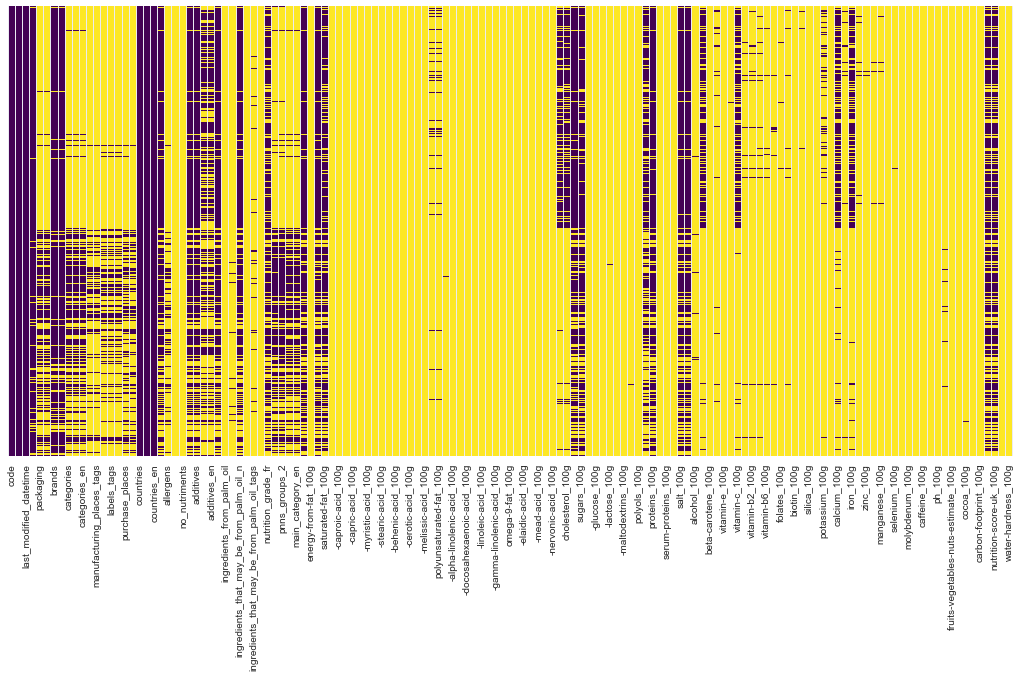

In [9]:
# generate a heatmap to observe were we have the most null values

sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## as we can see, many columns are almost empty. So, we can set a reasonable threshold and keep columns that have a sufficient number of non-null entries:

In [8]:
# 100.000 is about 1/3 of the entries

data.dropna(thresh=100000, axis=1, inplace=True)

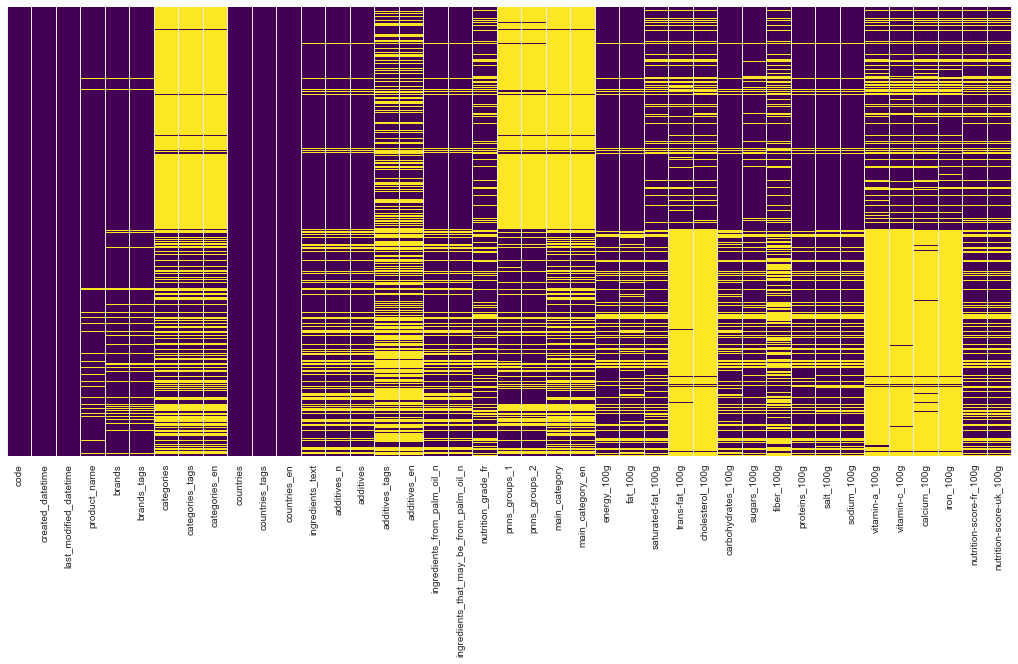

In [18]:
# lets check the heatmap again

sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
# this looks much better, lets delete all rows with no code, created_datetime,last_modified_datetime 
# or product name

data.dropna(subset=['code'], inplace=True)
data.dropna(subset=['created_datetime'], inplace=True)
data.dropna(subset=['last_modified_datetime'], inplace=True)
data.dropna(subset=['product_name'], inplace=True)

In [10]:
# Since we will use the nutrition score, lets remove all rows that have null nutritional score.
# We could fill the null values with the mean or median but that may lead to incorrect results in the analysis.

data.dropna(subset=['nutrition-score-fr_100g'], inplace=True)
data.dropna(subset=['nutrition-score-uk_100g'], inplace=True)

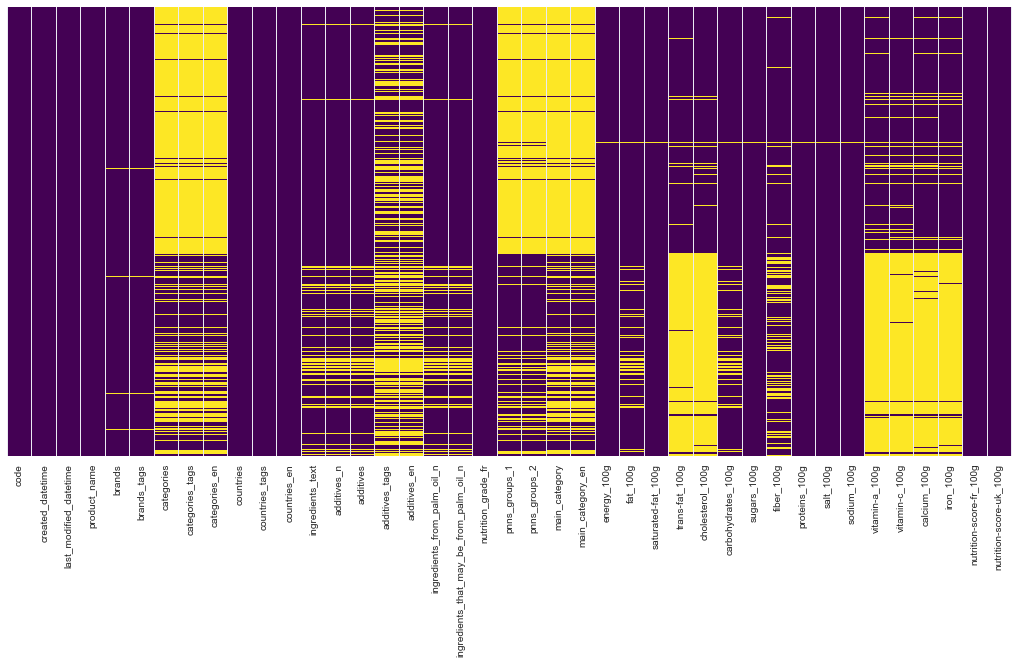

In [21]:
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [11]:
# Lets drop all the sparse categorical columns and keep only those that we will work with:

data.drop(['categories', 'categories_tags', 'categories_en','additives_n', 'additives', 
           'additives_tags', 'additives_en', 'pnns_groups_1', 'pnns_groups_2', 'main_category', 
           'main_category_en'], axis=1, inplace=True)

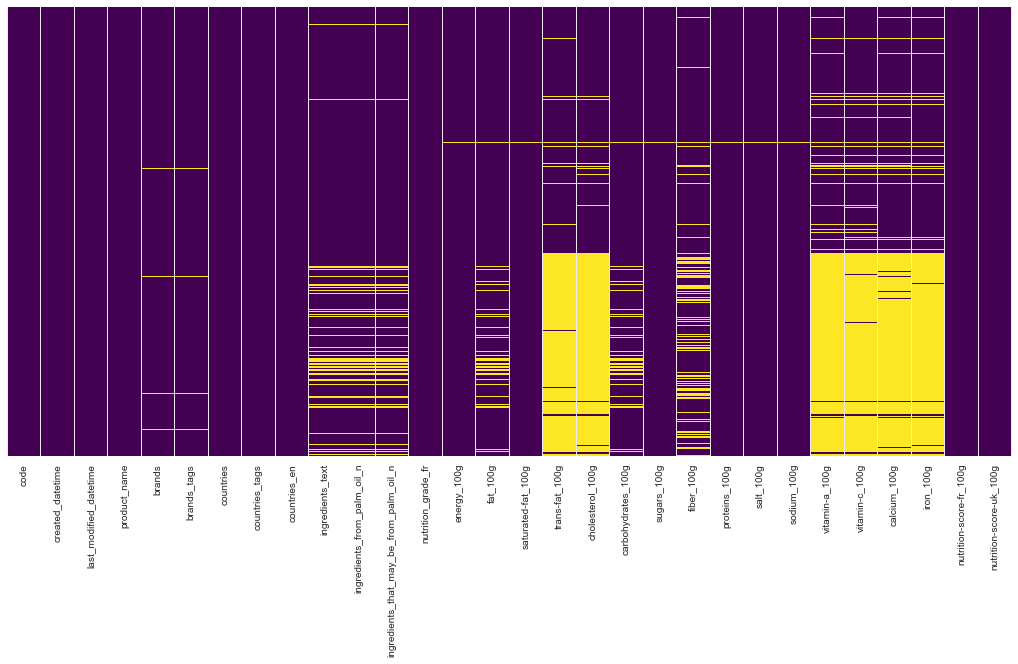

In [14]:
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [12]:
# Most remaining null values are in the numerical columns. 
# We could fill the null values by the mean of each column, or by the value zero 
# (assuming that a missing value means zero). Since all these columns affect the nutrition
# score, we will go the safe way to remove all null values:

data.dropna(inplace=True)
data.isnull().sum().sum()

0

In [13]:
# we managed to keep more than 1/3 of the entries

data.shape

(125306, 30)

In [14]:
# reset the index...
data.reset_index(drop=True, inplace=True)

## we dealt with null values, now lets format the data

In [15]:
# it appears that the 'code' column has mixed types:

data['code_dtype'] = data['code'].apply(lambda x: str(type(x)))
data.groupby('code_dtype').count()['code']

code_dtype
<class 'float'>         3
<class 'int'>      122823
<class 'str'>        2480
Name: code, dtype: int64

In [16]:
# Ideally we want all codes to be integers or strings. float codes appear to be very large so we will 
# remove all rows with float codes.

data = data[data['code_dtype'] != "<class 'float'>"]
data.reset_index(drop=True, inplace=True)

In [17]:
# Some string codes are very large and we cannot convert them to int64. We could then convert every int code
# to a string but since the string codes are very few (<2%) we will just drop them

data = data[data['code_dtype'] != "<class 'str'>"]
data.reset_index(drop=True, inplace=True)

In [18]:
data['code'] = pd.to_numeric(data['code'])

In [19]:
# drop the auxiliary column and check dtypes

data.drop('code_dtype', axis=1, inplace=True)
data.dtypes

code                                         int64
created_datetime                            object
last_modified_datetime                      object
product_name                                object
brands                                      object
brands_tags                                 object
countries                                   object
countries_tags                              object
countries_en                                object
ingredients_text                            object
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
nutrition_grade_fr                          object
energy_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
trans-fat_100g                             float64
cholesterol_100g                           float64
carbohydrates_100g                         float64
sugars_100g                    

In [20]:
# convert to datetime objects:

data['created_datetime'] = pd.to_datetime(data['created_datetime'])
data['last_modified_datetime'] = pd.to_datetime(data['last_modified_datetime'])

In [21]:
# brands_tags seems to be better formatted than brands, so we drop brands:

data.drop('brands', axis=1, inplace=True)

In [22]:
# replace characters of length 1 between '-' and commas
# we can take advantage of the fact that each string has no whitespaces

for i in range(2): #we run it twice to capture strange cases like '-g-d-' or '-g-v'
    data['brands_tags'] = data['brands_tags'].str.replace('(-.-)', '-')
    data['brands_tags'] = data['brands_tags'].str.replace('(^.-)', '')
    data['brands_tags'] = data['brands_tags'].str.replace('(-.$)', '')

    data['brands_tags'] = data['brands_tags'].str.replace('(,.,)', ',')
    data['brands_tags'] = data['brands_tags'].str.replace('(^.,)', '')
    data['brands_tags'] = data['brands_tags'].str.replace('(,.$)', '')

In [23]:
# remove any numbers between '-'

data['brands_tags'] = data['brands_tags'].str.replace('(-\d+-)', '-')
data['brands_tags'] = data['brands_tags'].str.replace('(^\d+-)', '')
data['brands_tags'] = data['brands_tags'].str.replace('(-\d+$)', '')

# remove any numbers inside the text, since we know they dont exist between '-'
data['brands_tags'] = data['brands_tags'].str.replace('(\d+)', '')

In [24]:
# now we check which countries columns to use and clean.
# it seems that 'countries_en' is better that the other two...

data.drop(['countries', 'countries_tags'], axis=1, inplace=True)

In [25]:
# for each entry we create a list of countries. 
# then we clear any whitespace at the start and end of each country

data['countries_en'] = data['countries_en'].str.split(',')

In [26]:
def clearwhitesp(listofstr):
    for i in range(len(listofstr)):
        listofstr[i] = listofstr[i].strip()
    return listofstr

data['countries_en'] = data['countries_en'].apply(clearwhitesp)

In [27]:
# now we deal with the ingredients_text column which is apparently very messy

In [28]:
data['ingredients_text'] = data['ingredients_text'].str.lower()

In [29]:
# we first remove unnecessary characters

data['ingredients_text'] = data['ingredients_text'].str.replace('.', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('_', '')
data['ingredients_text'] = data['ingredients_text'].str.replace("'", ' ')
data['ingredients_text'] = data['ingredients_text'].str.replace('/', '')
data['ingredients_text'] = data['ingredients_text'].str.replace(';', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('%', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('+', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('-', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('=', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('&', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('*', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('?', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('•', ',')
data['ingredients_text'] = data['ingredients_text'].str.replace('#', '')
data['ingredients_text'] = data['ingredients_text'].str.replace('—', ',')
data['ingredients_text'] = data['ingredients_text'].str.replace('\t', ',')
data['ingredients_text'] = data['ingredients_text'].str.replace('(\d+)', '')

In [30]:
# remove anything contained in (), [] or {} for easier analysis

def remove_parentheses(text): #takes into account nested parentheses
    n = 1
    while n: 
        text, n = re.subn(r'\([^()]*\)', '', text)
    return text

def remove_brackets(text): 
    n = 1 
    while n: 
        text, n = re.subn(r'\[[^[]*\]', '', text)
    return text

def remove_braces(text): 
    n = 1
    while n: 
        text, n = re.subn(r'\{[^{}]*\}', '', text)
    return text

data['ingredients_text'] = data['ingredients_text'].apply(remove_parentheses)
data['ingredients_text'] = data['ingredients_text'].apply(remove_brackets)
data['ingredients_text'] = data['ingredients_text'].apply(remove_braces)

In [31]:
# remove length-1 words

data['ingredients_text'] = data['ingredients_text'].str.replace('( \w )', ' ')
data['ingredients_text'] = data['ingredients_text'].str.replace('( \w,)', ',')

# remove categories inside ingredients, e.g. ", Contains less than 2% :"

def remove_categ(text): 
    n = 1 # run at least once 
    while n: 
        text, n = re.subn(r'\,[^,:]*\:', '', text)
    return text

data['ingredients_text'] = data['ingredients_text'].apply(remove_categ)

In [32]:
# some more replacements...
data['ingredients_text'] = data['ingredients_text'].str.replace(')', ',')
data['ingredients_text'] = data['ingredients_text'].str.replace('(', ',')
data['ingredients_text'] = data['ingredients_text'].str.replace('[', '')
data['ingredients_text'] = data['ingredients_text'].str.replace(']', '')
data['ingredients_text'] = data['ingredients_text'].str.replace(':', ',')
data['ingredients_text'] = data['ingredients_text'].str.replace(' and ', ',')

data['ingredients_text'].value_counts()

almonds                                                                                                                                                                                                                                                                                                                                                                                  264
potatoes, vegetable oil , salt                                                                                                                                                                                                                                                                                                                                                           167
walnuts                                                                                                                                                                                                                                       

In [33]:
# create a list of ingredients for each entry:

data['ingredients_text'] = data['ingredients_text'].str.split(',')

In [34]:
# clear start/end whitespaces for each ingredient

data['ingredients_text'] = data['ingredients_text'].apply(clearwhitesp)

In [35]:
# we define a function that drops too small(<3 chars) or too large(>20 chars) ingredients (junk)
def filter_ingred(listofing):
    listofing[:] = [x for x in listofing if len(x)>2 and len(x)<21]
    return listofing
        
data['ingredients_text'] = data['ingredients_text'].apply(filter_ingred)

In [36]:
# ingredients from palm oil columns are ok

data['ingredients_from_palm_oil_n'].value_counts()

0.0    122808
1.0        15
Name: ingredients_from_palm_oil_n, dtype: int64

In [37]:
# check dtype again
data['ingredients_that_may_be_from_palm_oil_n'] = data['ingredients_that_may_be_from_palm_oil_n'].astype(int)
data.dtypes

code                                                int64
created_datetime                           datetime64[ns]
last_modified_datetime                     datetime64[ns]
product_name                                       object
brands_tags                                        object
countries_en                                       object
ingredients_text                                   object
ingredients_from_palm_oil_n                       float64
ingredients_that_may_be_from_palm_oil_n             int64
nutrition_grade_fr                                 object
energy_100g                                       float64
fat_100g                                          float64
saturated-fat_100g                                float64
trans-fat_100g                                    float64
cholesterol_100g                                  float64
carbohydrates_100g                                float64
sugars_100g                                       float64
fiber_100g    

In [38]:
# the 'ingredients_from_palm_oil_n' column has almost all entries zero so we will remove it
# we will keep 'ingredients_that_may_be_from_palm_oil_n' 

data.drop('ingredients_from_palm_oil_n', axis=1, inplace=True)

In [39]:
# the two nutrition score columns are very similar:

np.abs(data['nutrition-score-fr_100g'] - data['nutrition-score-uk_100g']).mean()

0.01177303925160597

In [40]:
# we will take the average of the two scores to work with and drop the original scores

data['avg_nutr_score'] = (data['nutrition-score-fr_100g'] + data['nutrition-score-uk_100g']) / 2

data.drop(['nutrition-score-fr_100g', 'nutrition-score-uk_100g'], axis=1, inplace=True)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122823 entries, 0 to 122822
Data columns (total 25 columns):
code                                       122823 non-null int64
created_datetime                           122823 non-null datetime64[ns]
last_modified_datetime                     122823 non-null datetime64[ns]
product_name                               122823 non-null object
brands_tags                                122823 non-null object
countries_en                               122823 non-null object
ingredients_text                           122823 non-null object
ingredients_that_may_be_from_palm_oil_n    122823 non-null int64
nutrition_grade_fr                         122823 non-null object
energy_100g                                122823 non-null float64
fat_100g                                   122823 non-null float64
saturated-fat_100g                         122823 non-null float64
trans-fat_100g                             122823 non-null float64
cholesterol_1

In [42]:
# remove negative values and outliers from float columns with 3-std rule:

for column in list(data.columns)[9:24]:
    data[column] = np.abs(data[column])
    

for column in list(data.columns)[9:24]:
    data = data[np.abs(data[column] - data[column].mean()) <= (3 * data[column].std())]

In [43]:
data.reset_index(drop=True, inplace=True)

## Now that the data are cleaned we begin the analysis

## 1: some questions concerning the 5 most common countries, nutrition grade and fat-to-energy ratio

In [59]:
#load the columns we need in a new dataframe

db = data.loc[:, ['code', 'countries_en', 'avg_nutr_score', 'nutrition_grade_fr' ,'fat_100g', 'energy_100g']]
db.head()

,code,countries_en,avg_nutr_score,nutrition_grade_fr,fat_100g,energy_100g
0,4559,[United States],0.0,b,17.86,1941.0
1,33640,[United States],6.0,c,10.91,1824.0
2,33688,[United States],14.0,d,42.86,2389.0
3,43595,[United States],8.0,c,0.00,1255.0
4,45292,[United States],8.0,c,0.00,1046.0


In [60]:
# 5 most common countries in the dataset

top5 = ['United States', 'United Kingdom', 'France', 'Canada', 'Switzerland']

In [61]:
# db1 contains all the products sold in more than 1 countries

db1 = db[db['countries_en'].apply(lambda x: len(x)) > 1]
db1.reset_index(drop=True, inplace=True)
db1.head(3)

,code,countries_en,avg_nutr_score,nutrition_grade_fr,fat_100g,energy_100g
0,9800895250,"[France, United States]",23.0,e,32.4,2260.0
1,15839008219,"[France, United States]",0.0,b,25.0,2092.0
2,16000275348,"[France, United States]",14.0,d,3.7,1700.0


In [62]:
# db2 contains all the products sold in one country

db2 = db[db['countries_en'].apply(lambda x: len(x)) == 1]
db2.reset_index(drop=True, inplace=True)
db2.head(3)

,code,countries_en,avg_nutr_score,nutrition_grade_fr,fat_100g,energy_100g
0,4559,[United States],0.0,b,17.86,1941.0
1,33640,[United States],6.0,c,10.91,1824.0
2,33688,[United States],14.0,d,42.86,2389.0


In [63]:
# db2 contains all original entries but 

db2['countries_en'] = db2['countries_en'].apply(lambda x: x[0])

for i in range(db1.shape[0]):
    for country in db1.loc[i, 'countries_en']:
        for j in range(5):
            if country == top5[j]:
                db1.iloc[i, 1] = country
                db2 = db2.append(db1.iloc[i,:])

In [64]:
db2['countries_en'].value_counts()

United States                106712
France                          109
Canada                          104
United Kingdom                   12
Switzerland                       9
Tunisia                           2
Saint Pierre and Miquelon         1
Russia                            1
Colombia                          1
Hong Kong                         1
Name: countries_en, dtype: int64

In [65]:
# make copies of products that are sold in more that one countries so the 'countries' column
# contains only one string

db2.reset_index(drop=True, inplace=True)

db2 = db2[db2['countries_en'].apply(lambda x: x in top5)]
db2.reset_index(drop=True, inplace=True)

db2['countries_en'].value_counts()

United States     106712
France               109
Canada               104
United Kingdom        12
Switzerland            9
Name: countries_en, dtype: int64

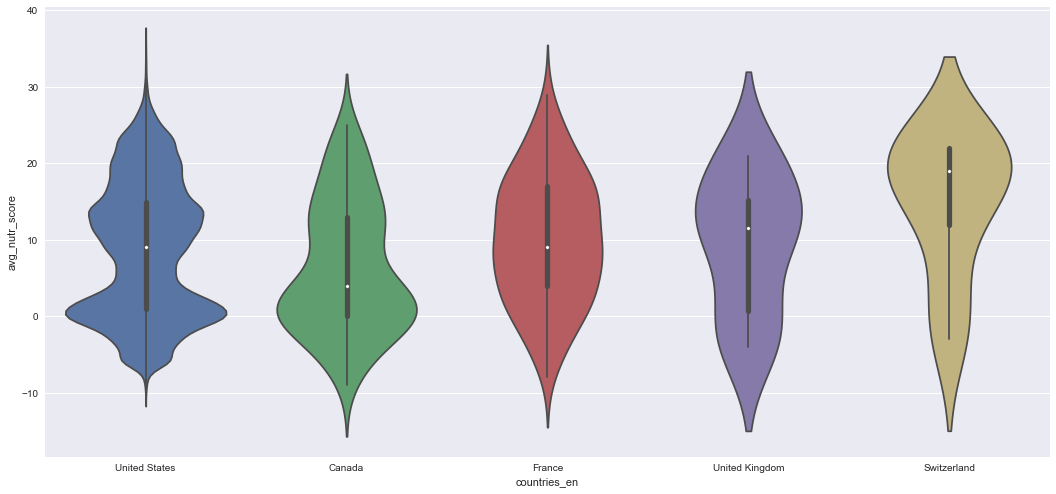

In [66]:
# average nutrition score per country

sns.violinplot(x='countries_en', y='avg_nutr_score', data=db2)

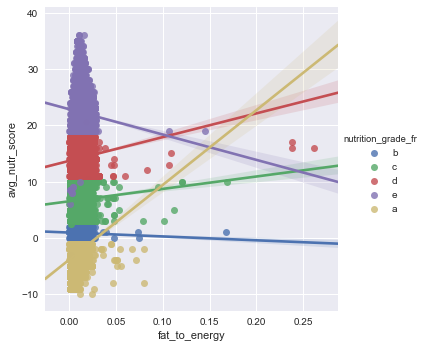

In [67]:
# compute fat-to-energy ratio and compare with nutrition grade

db2 = db2[db2['energy_100g'] != 0]
db2['fat_to_energy'] = db2['fat_100g'] / db2['energy_100g']
db2 = db2[db2['fat_to_energy'] != 0]

sns.lmplot(x='fat_to_energy', y='avg_nutr_score', data=db2, hue='nutrition_grade_fr')

## 2. finding the most common ingredients

In [50]:
ing_list = []
for lista in data['ingredients_text']:
    ing_list.extend(lista)
    
ingdf = pd.DataFrame(ing_list, columns=['ingredient'])
ingdf.head(10)

,ingredient
0,peanuts
1,wheat flour
2,sugar
3,rice flour
4,tapioca starch
5,salt
6,leavening
7,soy sauce
8,potato starch
9,whole rolled oats


In [51]:
ingdf['ingredient'].value_counts().head(10)

salt              49321
sugar             44350
water             38271
citric acid       14811
corn syrup        12325
sea salt          10827
spices             9210
natural flavor     8500
soybean oil        8079
dextrose           7484
Name: ingredient, dtype: int64

In [52]:
# take into account french words and convert sea salt to salt for more accurate results

ingdf['ingredient'] = ingdf['ingredient'].replace({'sel':'salt', 'sucre':'sugar', 'eau':'water', 'sea salt':'salt'})

In [53]:
# 5 most common ingredients:

ingdf['ingredient'].value_counts().head(5)

salt           60230
sugar          44404
water          38321
citric acid    14811
corn syrup     12325
Name: ingredient, dtype: int64

## 3. Time-series analysis

In [54]:
# Since we will work only with the two columns we import them from the original data for more entries:

datetime = pd.read_csv('en.openfoodfacts.org.products.tsv', sep='\t', usecols=[4,6])
datetime.dropna(inplace=True)
datetime.reset_index(drop=True, inplace=True)
datetime.head()

,created_datetime,last_modified_datetime
0,2016-09-17T09:17:46Z,2016-09-17T09:18:13Z
1,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z
2,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z
3,2017-03-09T10:35:31Z,2017-03-09T10:35:31Z
4,2017-03-09T10:34:13Z,2017-03-09T10:34:13Z


In [55]:
# remove faulty entries

datetime = datetime[datetime['created_datetime'].str.len() == 20]
datetime = datetime[datetime['last_modified_datetime'].str.len() == 20]

In [56]:
datetime['created_datetime'] = pd.to_datetime(datetime['created_datetime'])
datetime['last_modified_datetime'] = pd.to_datetime(datetime['last_modified_datetime'])

In [57]:
datetime.shape

(356000, 2)

In [58]:
datetime['difference'] = datetime['last_modified_datetime'] - datetime['created_datetime']

In [59]:
datetime['diff_in_min'] = datetime['difference'].apply(lambda x: (x.total_seconds()) // 60)

In [60]:
datetime.head()

,created_datetime,last_modified_datetime,difference,diff_in_min
0,2016-09-17 09:17:46,2016-09-17 09:18:13,00:00:27,0.0
1,2017-03-09 14:32:37,2017-03-09 14:32:37,00:00:00,0.0
2,2017-03-09 14:32:37,2017-03-09 14:32:37,00:00:00,0.0
3,2017-03-09 10:35:31,2017-03-09 10:35:31,00:00:00,0.0
4,2017-03-09 10:34:13,2017-03-09 10:34:13,00:00:00,0.0


In [61]:
# average difference in minutes

datetime['diff_in_min'].mean()

155734.9196264045

In [62]:
datetime = datetime.sort_values('created_datetime')
datetime.head()

,created_datetime,last_modified_datetime,difference,diff_in_min
272963,2012-01-31 14:43:58,2016-12-23 16:38:19,1788 days 01:54:21,2574834.0
193715,2012-02-09 10:34:56,2016-12-23 16:38:19,1779 days 06:03:23,2562123.0
222033,2012-02-11 14:51:07,2017-04-21 16:59:58,1896 days 02:08:51,2730368.0
201859,2012-02-11 18:51:58,2014-06-27 16:50:06,866 days 21:58:08,1248358.0
333176,2012-02-11 20:46:21,2017-08-25 07:10:45,2021 days 10:24:24,2910864.0


In [63]:
# set index to created_datetime
datetime = datetime.set_index('created_datetime')

In [64]:
# drop auxiliary columns
datetime.drop(['difference', 'diff_in_min'], axis=1, inplace=True)

In [65]:
# We count how many entries were created per month and then take the mean of all those counts

permonth = datetime.resample('M').count()
permonth['mean'] = [permonth['last_modified_datetime'].mean()] * len(permonth['last_modified_datetime'])

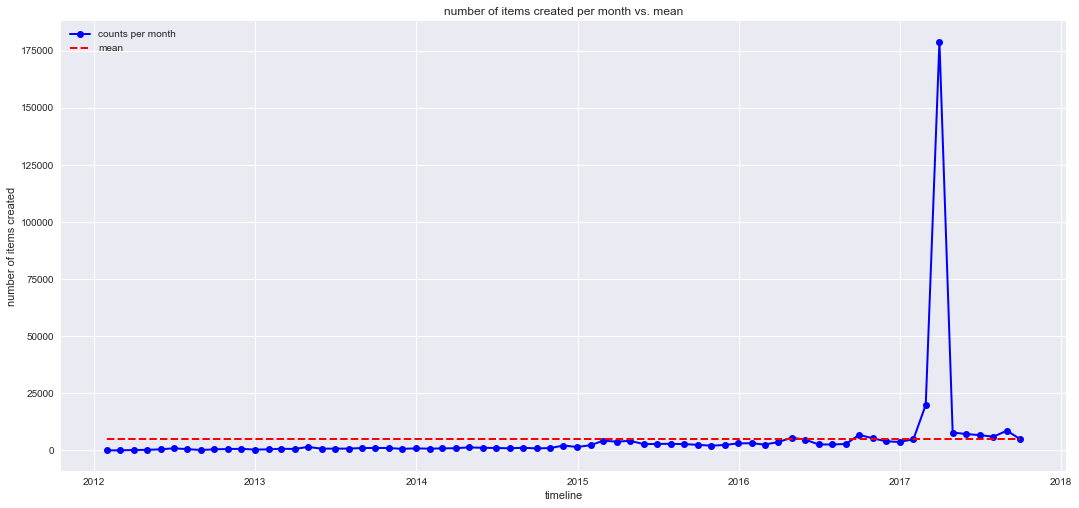

In [70]:
plt.plot(permonth.index, permonth['last_modified_datetime'], color='blue', lw=2, marker='o', label='counts per month')
plt.plot(permonth.index, permonth['mean'], color='red', lw=2, ls='--', label='mean')
plt.xlabel('timeline')
plt.ylabel('number of items created')
plt.title('number of items created per month vs. mean')
plt.legend(loc='upper left')
plt.show()

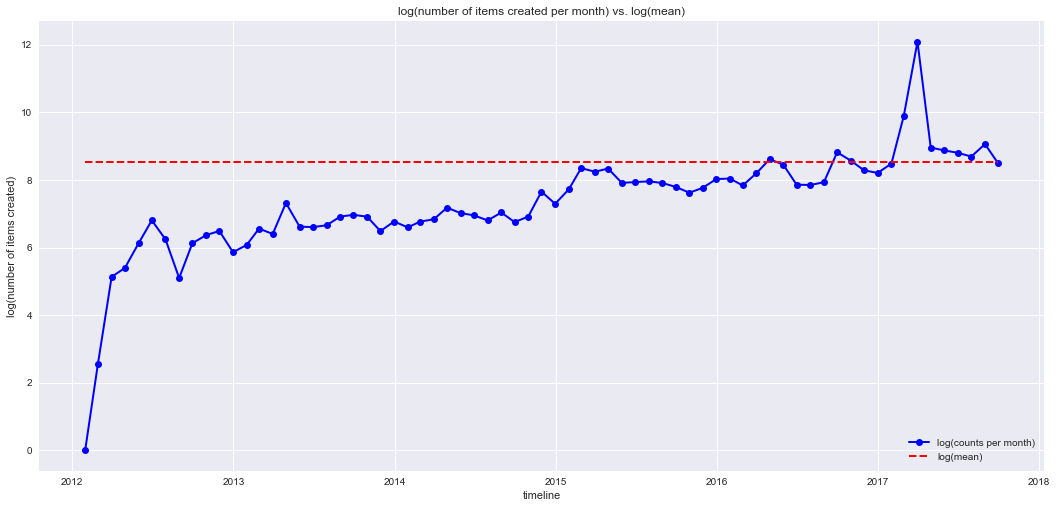

In [71]:
# We observe that there is a big spike in the graph that 'buries' all values, so we plot the log:

plt.plot(permonth.index, np.log(permonth['last_modified_datetime']), color='blue', 
         lw=2, marker='o', label='log(counts per month)')
plt.plot(permonth.index, np.log(permonth['mean']), color='red', lw=2, ls='--', label='log(mean)')
plt.xlabel('timeline')
plt.ylabel('log(number of items created)')
plt.title('log(number of items created per month) vs. log(mean)')
plt.legend(loc='lower right')
plt.show()

## 4. DataBase

In [ ]:
# we will use the first 1000 entries and the columns code (as primary key), product name, energy, sugars and fat

df = data.loc[0:999, ['code', 'product_name', 'energy_100g', 'fat_100g', 'sugars_100g']]
df.head()

In [ ]:
# connection to sqlite3 database

db = sqlite3.connect('courseproject.db')
cursor = db.cursor()

In [ ]:
# create the table

cursor.execute("CREATE TABLE foods (code INTEGER PRIMARY KEY, product_name TEXT, energy_100g FLOAT, fat_100g FLOAT, sugars_100g FLOAT);")
db.commit()

In [ ]:
# check that table was created

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';") 
results = cursor.fetchall() 
print(results)

In [ ]:
# load the dataframe df to the database foods

df.to_sql(name='foods', con=db, if_exists='append', index=False)

In [ ]:
def run_query(query):
    return pd.read_sql_query(query,db)

In [ ]:
# check that it works properly: find the top 5 products w.r.t. energy

run_query("SELECT code, product_name, energy_100g FROM foods ORDER BY energy_100g DESC LIMIT 5;")

In [ ]:
run_query("SELECT * FROM foods WHERE code=78684962026;")

In [ ]:
db.close() #close connection to database

## 5. Analysis of nutrition score

In [71]:
df2 = data.loc[:, ['energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'avg_nutr_score']]

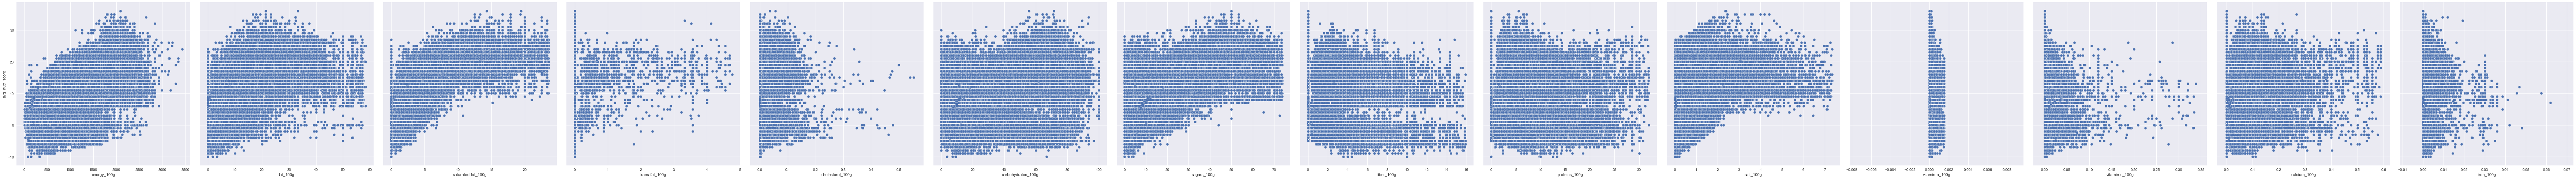

In [72]:
sns.pairplot(data=df2, y_vars='avg_nutr_score', x_vars=df2.drop(['avg_nutr_score'], axis=1).columns , aspect=1, size=7)

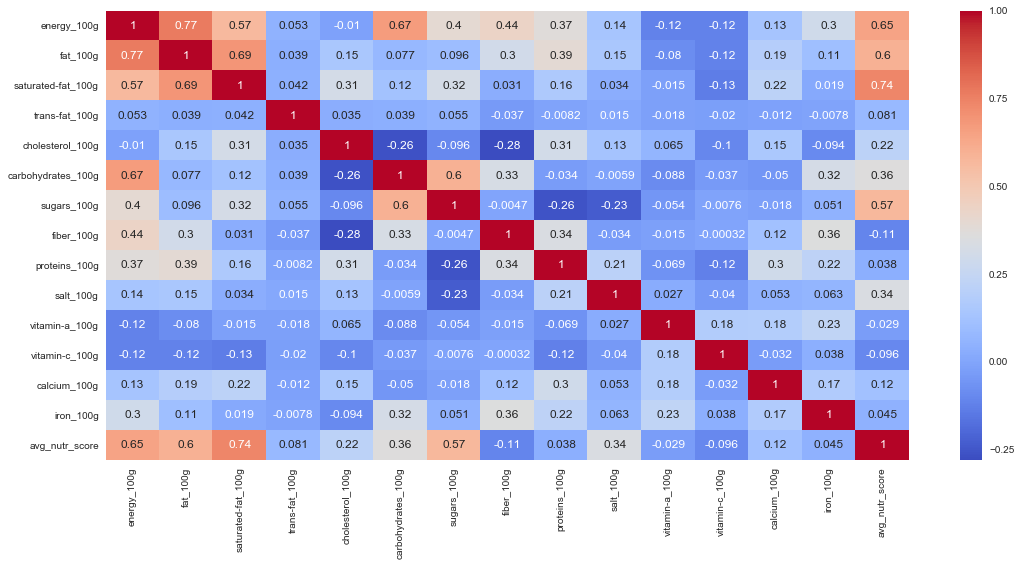

In [73]:
sns.heatmap(df2.corr(),cmap='coolwarm',annot=True)

In [126]:
# attributes that cause high nutrition score:

for column in list(df2.columns[0:14]):
    if np.corrcoef(df2[column], df2['avg_nutr_score'])[0,1] > 0.5:
        print(column, ':' ,np.corrcoef(df2[column], df2['avg_nutr_score'])[0,1])

energy_100g : 0.6803633099136007
fat_100g : 0.5917819469199996
saturated-fat_100g : 0.7519404169468225
sugars_100g : 0.566823420100471


In [127]:
# attributes that cause lower nutrition score:

for column in list(df2.columns[0:14]):
    if np.corrcoef(df2[column], df2['avg_nutr_score'])[0,1] < 0:
        print(column, ':', np.corrcoef(df2[column], df2['avg_nutr_score'])[0,1])

fiber_100g : -0.03905143520260294
vitamin-a_100g : -0.03957360856215992
vitamin-c_100g : -0.10932281115979943
